The **ptd** module of the **ppi_py** package implements the Predict-then-Debias (PTD) bootstrap algorithm from Kluger et al. (2025), 'Prediction-Powered Inference with Imputed Covariates and Nonuniform Sampling,' <https://arxiv.org/abs/2501.18577>. The algorithm takes in an estimator of interest, a large "unlabeled" dataset of machine learning predictions, and a small "calibration" dataset of ground truth measurements. It outputs valid point estimates and confidence intervals for the estimator of interest.  

In this notebook, we demonstrate how to use the ptd module to estimate linear regression and logistic regression coefficients. We also show how users can use the module on their own estimators of interest. 

We compare results from PTD with the "classical" estimator (using calibration ground truth points only) and "naive" estimator (using predictions only). By combining ground truth and predicted datasets, PTD produces statistically valid confidence intervals that are narrower than those for the classical estimator.

# Import packages

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import statsmodels

from ppi_py.datasets.datasets import load_dataset
from ppi_py import ptd

# Baseline methods for comparison

In [7]:
from statsmodels.regression.linear_model import WLS, RegressionResults
from statsmodels.stats.weightstats import _zconfint_generic
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit

def classical_logistic_regression_ci(X, Y, w=None, alpha=0.05):
    """
    Computes confidence intervals for logistic regression coefficients using the classical method.

    Args:
        X (ndarray): labeled covariates (dimensions n x p)
        Y (ndarray): labeled responses (length n)
        w (ndarray, optional): sample weights for the labeled dataset (length n)
        alpha (float, optional): error level (must be in the range (0, 1)). Confidence interval will target a coverage of 1 - alpha.

    Returns:
        tuple: lower and upper bounds of classical confidence intervals for the coefficients
    """
    regression = GLM(endog=Y, exog=X, freq_weights=w, family=Binomial(link=Logit())).fit()
    ci = regression.conf_int(alpha=alpha).T
    return ci

def classical_linear_regression_ci(X, Y, w=None, alpha=0.05):
    """
    Computes confidence intervals for linear regression coefficients using the classical method.

    Args:
        X (ndarray): labeled covariates (dimensions n x p)
        Y (ndarray): labeled responses (length n)
        w (ndarray, optional): sample weights for the labeled dataset (length n)
        alpha (float, optional): error level (must be in the range (0, 1)). Confidence interval will target a coverage of 1 - alpha.

    Returns:
        tuple: lower and upper bounds of classical confidence intervals for the coefficients
    """
    if w is None:
        regression = WLS(endog=Y, exog=X).fit()
    else:
        regression = WLS(endog=Y, exog=X, weights=w).fit()
    coeff = regression.params
    se = regression.HC0_se
    ci = _zconfint_generic(coeff, se, alpha, alternative="two-sided")
    return (ci[0], ci[1])

# Load dataset (tree cover, elevation, population)

We use the MOSAIKS dataset from (Rolf et al, 2021). The dataset contains both ground truth and predicted values for tree cover, elevation, and population variables in the contiguous United States.

After dropping points with missing variables, there are N=67968 total points. For each of our experiments, we will use a uniformly random sampled subset of the points as a calibration dataset (with ground truth and predicted values available), and use the rest as an unlabeled dataset (with predicted values only).

E. Rolf, J. Proctor, T. Carleton, I. Bolliger, V. Shankar, M. Ishihara, B. Recht, and S. Hsiang. "A Generalizable and Accessible Approach to Machine Learning with Global Satellite Imagery," Nature Communications, 2021. https://github.com/Global-Policy-Lab/mosaiks-paper

In [3]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "tree_cover")
data = pd.DataFrame.from_dict({item: data[item] for item in data.files})
data

Dataset tree_cover not found at location ./data/; downloading now...


,truth_tree,preds_tree,lon,lat,truth_elevation,preds_elevation,truth_population,preds_population
0,0.000000,0.000000,-119.794019,46.773157,0.423914,0.963784,0.290985,0.223613
1,0.000000,0.000000,-107.440142,36.628412,2.015408,1.779982,0.070059,1.089495
2,32.511176,42.111039,-87.580287,30.316254,0.005059,-0.016801,1.771785,2.923414
3,1.706111,0.000000,-102.316795,43.250483,1.000075,1.164283,2.654329,0.872536
4,34.121974,38.179145,-97.661712,29.815675,0.144380,0.310666,1.539581,1.788519
...,...,...,...,...,...,...,...,...
67963,0.056365,11.829323,-99.741350,32.537026,0.521323,0.422672,3.776049,3.563149
67964,1.926316,8.442633,-83.352149,41.014260,0.256471,0.174457,3.064954,2.710515
67965,2.947000,0.000000,-86.850348,36.650512,0.169112,0.125459,4.120613,3.165970
67966,0.084062,7.715938,-99.906619,31.509565,0.495074,0.488693,0.945092,1.091228


# Example 1: Linear regression coefficient estimation

In this example, we estimate linear regression coefficients relating tree cover to two covariates: elevation and population. 

We treat forest cover and population variables as if we only have access to ground truth for a small subset of the points. For elevation, we will use ground truth for all points.

In the code, truth_Y and truth_X are the full ground truth datasets for the response variable and covariates respectively. preds_Y and preds_X are the "predicted" datasets. Note that in this example, both truth_X and preds_X include ground truth elevation values (rather than predicted elevation values), because we are treating ground truth elevation as widely available. 

In [8]:
truth_Y = np.array(data['truth_tree']).reshape(-1, 1)
preds_Y = np.array(data['preds_tree']).reshape(-1, 1)

truth_X = np.array(data[['truth_elevation', 'truth_population']])
preds_X = np.array(data[['truth_elevation', 'preds_population']])

We randomly sample 500 points (out of the 67968 total points) to use as the calibration set. The remaining 67468 points are the unlabeled set.

In the code, X and Y are the true covariate and response variable values in the calibration set. Xhat and Yhat are the the predicted covariate and response variable values in the calibration set. Xhat_unlabeled and Yhat_unlabeled are the predicted covariate and response variable values in the unlabeled set. 

Note that we add a constant column to the covariate data arrays, so that the regression coefficients will include an intercept term.

In [9]:
np.random.seed(seed=100)
calibration_indices = np.random.choice(np.arange(0, len(data)), size=500, replace=False)
X = statsmodels.tools.add_constant(truth_X[calibration_indices])
Xhat = statsmodels.tools.add_constant(preds_X[calibration_indices])
Xhat_unlabeled = statsmodels.tools.add_constant(np.delete(preds_X, calibration_indices, axis=0)) # all predicted datapoints except calibration indices
Y = truth_Y[calibration_indices]
Yhat = preds_Y[calibration_indices]
Yhat_unlabeled = np.delete(preds_Y, calibration_indices, axis=0) # all predicted datapoints except calibration indices

We use the following functions to compute point estimates and confidence intervals for the linear regression coefficients. 

We use **algorithm_linear_regression** to compute the "true coefficient" using the full ground truth covariate and response datasets.

We use **ptd_linear_regression** to compute "PTD" point estimates and 95% confidence intervals using the calibration dataset and unlabeled dataset.

We use **classical_linear_regression_ci** to compute "classical" 95% confidence intervals using only the ground truth covariate and response values in the calibration set. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

We also use **classical_linear_regression_ci** to compute "naive" 95% confidence intervals using only the full predicted covariate and response datasets. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

In [10]:
true_coeff = ptd.algorithm_linear_regression(data=[statsmodels.tools.add_constant(truth_X), truth_Y], w=None)

tuning_matrix, ptd_pointestimate, ptd_ci = ptd.ptd_linear_regression(X, Xhat, Xhat_unlabeled, Y, Yhat, Yhat_unlabeled, 
                                                                  B=2000, alpha=0.05, tuning_method='optimal')

classical_ci = classical_linear_regression_ci(X, Y, alpha=0.05)
classical_pointestimate = (classical_ci[0]+classical_ci[1])/2

naive_ci = classical_linear_regression_ci(statsmodels.tools.add_constant(preds_X), preds_Y, alpha=0.05)
naive_pointestimate = (naive_ci[0]+naive_ci[1])/2

We visualize the coefficient point estimates and confidence intervals for PTD, classical, and naive estimators. 

The yellow dotted line is the "true coefficient." The effective sample size improvement of PTD compared to the classical confidence interval is shown in blue. 

We see that the naive estimates are biased relative to the true coefficient, while PTD has statistically valid confidence intervals (which, in the figure, contain the true coefficient). The PTD confidence intervals are also narrower than the classical confidence intervals.  

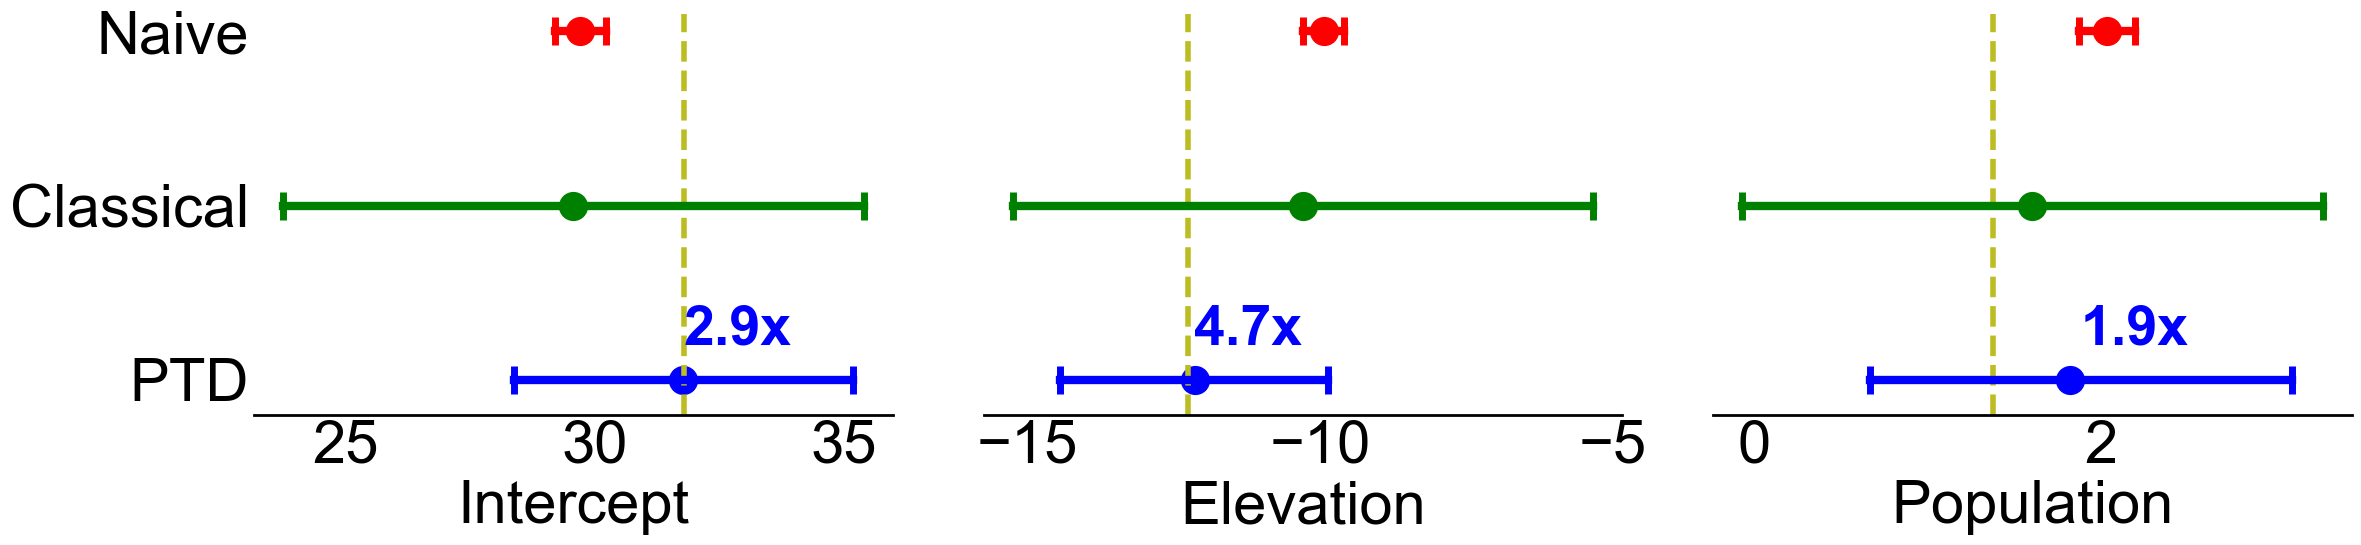

In [11]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=43)          
plt.rc('axes', titlesize=43)     
plt.rc('axes', labelsize=43)    
plt.rc('xtick', labelsize=43)    
plt.rc('ytick', labelsize=43)    
plt.rc('figure', titlesize=43)

covariates = ['Intercept', 'Elevation', 'Population']
pd.set_option("display.precision", 8)

fig = plt.figure(figsize=(32, 6.5))
colors = ['blue', 'green', 'red']
for i, covariate in enumerate(covariates):
        
    data_dict = {}
    classical_ci_width = classical_ci[1][i] - classical_ci[0][i]
    ptd_ci_width = ptd_ci[1][i] - ptd_ci[0][i]
    data_dict['category'] = ['PTD','Classical','Naive']
    data_dict['lower'] = [ptd_ci[0][i], classical_ci[0][i], naive_ci[0][i]]
    data_dict['upper'] = [ptd_ci[1][i], classical_ci[1][i], naive_ci[1][i]]
    data_dict['pointestimate'] = [ptd_pointestimate[i], classical_pointestimate[i], naive_pointestimate[i]]
    dataset = pd.DataFrame(data_dict)
    
    subplot = fig.add_subplot(141+i)
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)
    subplot.spines['left'].set_visible(False)
    subplot.spines['bottom'].set_linewidth(2)
    
    # show true coefficient (yellow dotted line)
    plt.axvline(true_coeff[i], color='tab:olive', linestyle='--', lw=4, label='True \ncoefficient')
    
    # plot confidence intervals
    for lower,upper,pointestimate,y in zip(dataset['lower'],dataset['upper'],dataset['pointestimate'],range(len(dataset))):
        subplot.scatter([pointestimate], [y], color=colors[y], s=400)
        subplot.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=400, lw=5)
        subplot.plot((lower,upper),(y,y),color=colors[y], lw=6)
        if y == 0:
            # compute PTD effective sample size improvement over classical method
            ptd_effective_n_improvement = np.round((classical_ci_width/ptd_ci_width)**2, 1)
            subplot.text((lower+upper)/2, 0.2, f'{ptd_effective_n_improvement}x', fontsize = 40, c='blue', weight='bold')
            
    subplot.tick_params(axis=u'both', which=u'both',length=0)
    if i == 0:
        subplot.set_yticks(range(len(dataset)),list(dataset['category']))
    else:
        subplot.set_yticks([])
    subplot.set_xlabel(f'{covariate}')
    subplot.set_ylim(-0.2)
    
plt.tight_layout()   
plt.show()

# Example 2: Logistic regression coefficient estimation

In this example, we estimate logistic regression coefficients relating tree cover to two covariates: elevation and population. 

This example is very similar to the previous example, except we use a binarized version of the tree cover response variable for the logistic regression. Tree cover values greater than 10% are mapped to 1, while tree cover values less than or equal to 10% are mapped to 0. 

In [12]:
truth_Y = np.array(data['truth_tree'] > 10, dtype=float).reshape(-1, 1)
preds_Y = np.array(data['preds_tree'] > 10, dtype=float).reshape(-1, 1)

truth_X = np.array(data[['truth_elevation', 'truth_population']])
preds_X = np.array(data[['truth_elevation', 'preds_population']])

We randomly sample 1000 points (out of the 67968 total points) to use as the calibration set. The remaining 66968 points are the unlabeled set.

In [13]:
np.random.seed(seed=100)
calibration_indices = np.random.choice(np.arange(0, len(data)), size=1000, replace=False)
X = statsmodels.tools.add_constant(truth_X[calibration_indices])
Xhat = statsmodels.tools.add_constant(preds_X[calibration_indices])
Xhat_unlabeled = statsmodels.tools.add_constant(np.delete(preds_X, calibration_indices, axis=0)) # all predicted datapoints except calibration indices
Y = truth_Y[calibration_indices]
Yhat = preds_Y[calibration_indices]
Yhat_unlabeled = np.delete(preds_Y, calibration_indices, axis=0) # all predicted datapoints except calibration indices

We use the following functions to compute point estimates and confidence intervals for the logistic regression coefficients.

We use **algorithm_logistic_regression** to compute the "true coefficient" using the full ground truth covariate and response datasets.

We use **ptd_logistic_regression** to compute "PTD" point estimates and 95% confidence intervals using the calibration dataset and unlabeled dataset.

We use **classical_logistic_regression_ci** to compute "classical" 95% confidence intervals using only the ground truth covariate and response values in the calibration set. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

We also use **classical_logistic_regression_ci** to compute "naive" 95% confidence intervals using only the full predicted covariate and response datasets. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

In [14]:
true_coeff = ptd.algorithm_logistic_regression(data=[statsmodels.tools.add_constant(truth_X), truth_Y], w=None)

tuning_matrix, ptd_pointestimate, ptd_ci = ptd.ptd_logistic_regression(X, Xhat, Xhat_unlabeled, Y, Yhat, Yhat_unlabeled, 
                                                                  B=2000, alpha=0.05, tuning_method='optimal')

classical_ci = classical_logistic_regression_ci(X, Y, alpha=0.05)
classical_pointestimate = (classical_ci[0]+classical_ci[1])/2

naive_ci = classical_logistic_regression_ci(statsmodels.tools.add_constant(preds_X), preds_Y, alpha=0.05)
naive_pointestimate = (naive_ci[0]+naive_ci[1])/2

We visualize the coefficient point estimates and confidence intervals for PTD, classical, and naive estimators.

The yellow dotted line is the "true coefficient." The effective sample size improvement of PTD compared to the classical confidence interval is shown in blue.

We see that the naive estimates are biased relative to the true coefficient, while PTD has statistically valid confidence intervals (which, in the figure, contain the true coefficient). The PTD confidence intervals for intercept and elevation are also narrower than the classical confidence intervals.

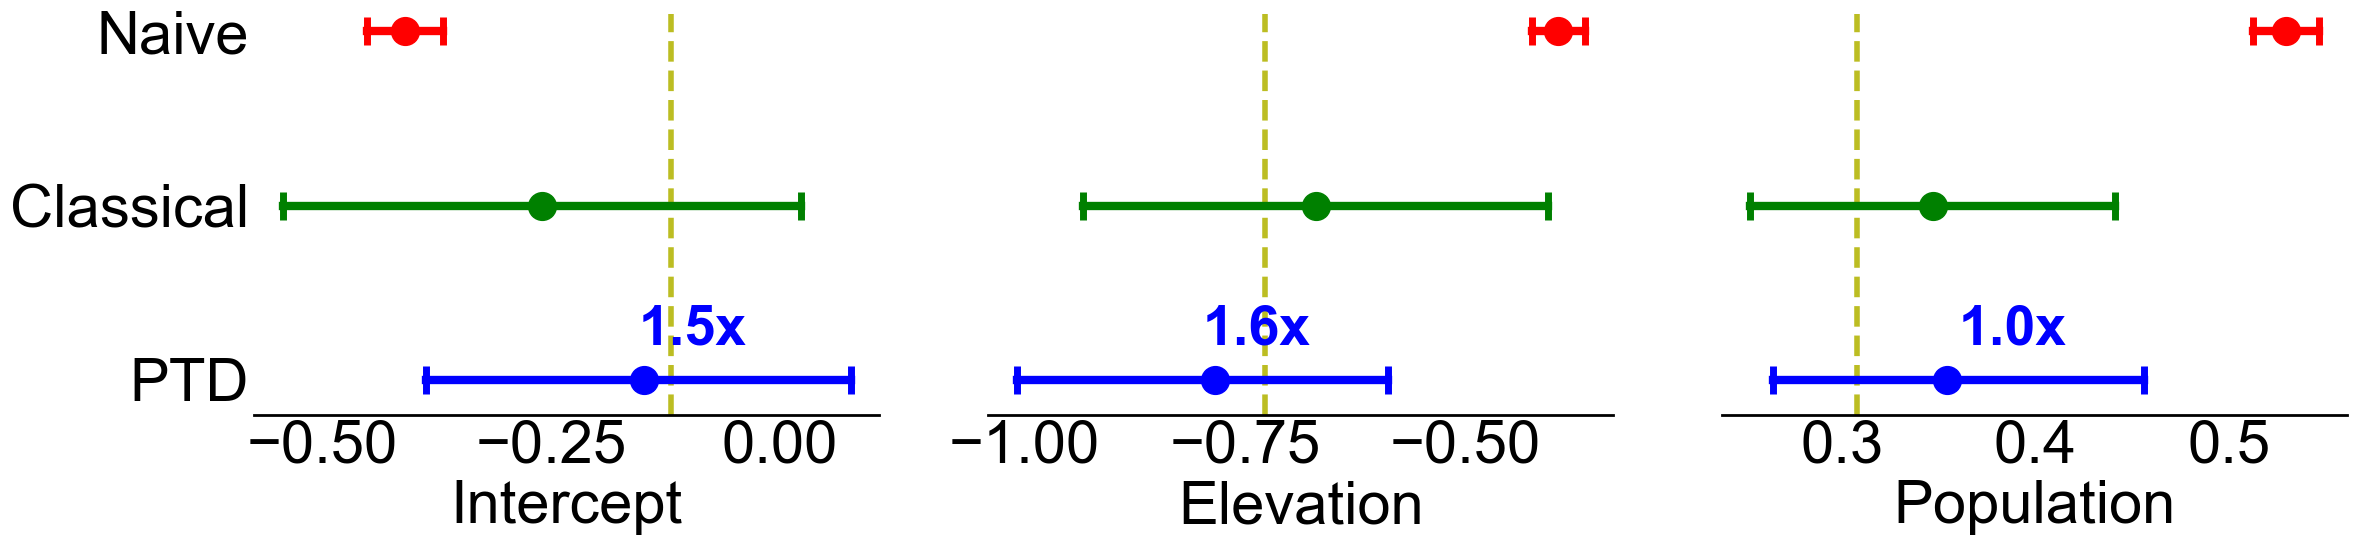

In [15]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=43)          
plt.rc('axes', titlesize=43)     
plt.rc('axes', labelsize=43)    
plt.rc('xtick', labelsize=43)    
plt.rc('ytick', labelsize=43)    
plt.rc('figure', titlesize=43)

covariates = ['Intercept', 'Elevation', 'Population']
pd.set_option("display.precision", 8)

fig = plt.figure(figsize=(32, 6.5))
colors = ['blue', 'green', 'red']
for i, covariate in enumerate(covariates):
        
    data_dict = {}
    classical_ci_width = classical_ci[1][i] - classical_ci[0][i]
    ptd_ci_width = ptd_ci[1][i] - ptd_ci[0][i]
    data_dict['category'] = ['PTD','Classical','Naive']
    data_dict['lower'] = [ptd_ci[0][i], classical_ci[0][i], naive_ci[0][i]]
    data_dict['upper'] = [ptd_ci[1][i], classical_ci[1][i], naive_ci[1][i]]
    data_dict['pointestimate'] = [ptd_pointestimate[i], classical_pointestimate[i], naive_pointestimate[i]]
    dataset = pd.DataFrame(data_dict)
    
    subplot = fig.add_subplot(141+i)
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)
    subplot.spines['left'].set_visible(False)
    subplot.spines['bottom'].set_linewidth(2)
    
    # show true coefficient (yellow dotted line)
    plt.axvline(true_coeff[i], color='tab:olive', linestyle='--', lw=4, label='True \ncoefficient')
    
    # plot confidence intervals
    for lower,upper,pointestimate,y in zip(dataset['lower'],dataset['upper'],dataset['pointestimate'],range(len(dataset))):
        subplot.scatter([pointestimate], [y], color=colors[y], s=400)
        subplot.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=400, lw=5)
        subplot.plot((lower,upper),(y,y),color=colors[y], lw=6)
        if y == 0:
            # compute PTD effective sample size improvement over classical method
            ptd_effective_n_improvement = np.round((classical_ci_width/ptd_ci_width)**2, 1)
            subplot.text((lower+upper)/2, 0.2, f'{ptd_effective_n_improvement}x', fontsize = 40, c='blue', weight='bold')
            
    subplot.tick_params(axis=u'both', which=u'both',length=0)
    if i == 0:
        subplot.set_yticks(range(len(dataset)),list(dataset['category']))
    else:
        subplot.set_yticks([])
    subplot.set_xlabel(f'{covariate}')
    subplot.set_ylim(-0.2)
    
plt.tight_layout()   
plt.show()

# Example 3: Using Predict-Then-Debias for an estimator of interest (quantile estimation)

Users can also use the ptd module to apply the PTD method on their own estimators of interest. 

As an example, we will show how to create a quantile estimation wrapper function around the ptd module's **ptd_bootstrap** function. We will then use the wrapper function to estimate the 0.8 quantile (80th percentile) value for tree cover.

The **ptd_bootstrap** function has the following inputs and outputs.

    Inputs:
        algorithm (function): python function that takes in data and weights, and returns array containing parameters of interest (e.g., a function that computes linear regression or logistic regression coefficients)
        data_truth (List[ndarray]): ground truth labeled data (each ndarray has n rows)
        data_pred (List[ndarray]): predicted labeled data (each ndarray has n rows)
        data_pred_unlabeled (List[ndarray]): predicted unlabeled data (each ndarray has N rows)
        w (ndarray, optional): sample weights for labeled data (length n)
        w_unlabeled (ndarray, optional): sample weights for unlabeled data (length N)
        B (int, optional): number of bootstrap steps
        alpha (float, optional): error level (must be in the range (0, 1)). The PTD confidence interval will target a coverage of 1 - alpha. 
        tuning_method (str, optional): method used to create the tuning matrix: "optimal_diagonal", "optimal", or None. (If tuning_method is None, the identity matrix is used.) 
        
    Outputs:
        ndarray: the tuning matrix (dimensions d x d) computed from the selected tuning method
        ndarray: PTD point estimate of the parameters of interest (length d)
        tuple: lower and upper bounds of PTD confidence intervals with (1-alpha) coverage

Below we define the **ptd_quantile** wrapper function for quantile estimation. Within **ptd_quantile**, we first define the **algorithm_quantile** function, which takes in a dataset and computes the selected empirical quantile. We then pass the **algorithm_quantile** function (along with the datasets and hyperparameters) into the **ptd_bootstrap** function, which will use the PTD method to compute the quantile point estimate and confidence interval. 

(Note that the first input to the **ptd_bootstrap** is required to be a python function that takes in two inputs (data and weights). So we define **algorithm_quantile** to have both data and weights as arguments, even though the weights are not used.) 

In [16]:
def ptd_quantile(X, Xhat, Xhat_unlabeled, quantile, B=2000, alpha=0.05, tuning_method='optimal_diagonal'):
    """
    Computes tuning matrix, point estimates, and confidence intervals for quantile estimation using the Predict-then-Debias bootstrap algorithm. 
    
    Args:
        X (ndarray): ground truth values in labeled data (dimensions n x 1)
        Xhat (ndarray): predicted values in labeled data (dimensions n x 1)
        Xhat_unlabeled (ndarray): predicted values in unlabeled data (dimensions N x 1)
        quantile (scalar): the desired quantile probability. Must be in the range [0, 1].
        B (int, optional): number of bootstrap steps
        alpha (float, optional): error level (must be in the range (0, 1)). The PTD confidence interval will target a coverage of 1 - alpha. 
        tuning_method (str, optional): method used to create the tuning matrix: "optimal_diagonal", "optimal", or None. (If tuning_method is None, the identity matrix is used.) 
        
    Returns:
        ndarray: the tuning matrix computed from the selected tuning method (1 x 1)
        ndarray: PTD point estimate of the quantile 
        tuple: lower and upper bounds of PTD confidence intervals with (1-alpha) coverage
    """
    def algorithm_quantile(data, weights):
        pointestimate = np.quantile(data, quantile)
        return np.array([pointestimate])
    
    # ptd_bootstrap requires input data arrays to be in list form (List[ndarray])
    data_truth = [X]
    data_pred = [Xhat]
    data_pred_unlabeled = [Xhat_unlabeled]
    
    return ptd.ptd_bootstrap(algorithm_quantile, data_truth, data_pred, data_pred_unlabeled, B=B, alpha=alpha, tuning_method=tuning_method)

We also define a function **classical_quantile_ci** which computes a confidence interval for a given quantile of a single dataset X. This will be used to compute "classical" (ground truth only) and "naive" (prediction only) quantile confidence intervals. 

For more information see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles_cimj.html

In [17]:
from scipy.stats.mstats import mquantiles_cimj

def classical_quantile_ci(X, quantile, alpha=0.05):
    ci = mquantiles_cimj(X, prob=quantile, alpha=alpha)
    return ci

We define truth_X as the full ground truth tree cover dataset, and preds_X as the full predicted tree cover dataset.

In [18]:
truth_X = np.array(data['truth_tree']).reshape(-1, 1)
preds_X = np.array(data['preds_tree']).reshape(-1, 1)

We randomly sample 500 points (out of the 67968 total points) to use as the calibration set. The remaining 67468 points are the unlabeled set.

In the code below, X contains the ground truth values in the calibration set, Xhat contains the predicted values in the calibration set, and Xhat_unlabeled contains the predicted values in the unlabeled set. 

In [19]:
np.random.seed(seed=100)
calibration_indices = np.random.choice(np.arange(0, len(data)), size=500, replace=False)
X = truth_X[calibration_indices]
Xhat = preds_X[calibration_indices]
Xhat_unlabeled = np.delete(preds_X, calibration_indices, axis=0) # all predicted datapoints except calibration indices

We compute point estimates and 95% confidence intervals for the 0.8 quantile value for tree cover. 

We use **np.quantile** to compute the true 0.8 quantile for tree cover using the full ground truth dataset. 

We use **ptd_quantile** to compute the "PTD" point estimate and 95% confidence interval using the calibration dataset and unlabeled dataset.

We use **classical_quantile_ci** to compute the "classical" 95% confidence interval using only the ground truth values in the calibration set. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

We also use **classical_quantile_ci** to compute the "naive" 95% confidence interval using only the full prediction dataset. The corresponding point estimates are computed by averaging the lower and upper confidence interval bounds. 

In [20]:
quantile = 0.8
true_coeff = [np.quantile(truth_X, quantile)]

tuning_matrix, ptd_pointestimate, ptd_ci = ptd_quantile(X, Xhat, Xhat_unlabeled, quantile, 
                                                                  B=2000, alpha=0.05, tuning_method='optimal')

classical_ci = classical_quantile_ci(X, quantile, alpha=0.05)
classical_pointestimate = (classical_ci[0]+classical_ci[1])/2

naive_ci = classical_quantile_ci(preds_X, quantile, alpha=0.05)
naive_pointestimate = (naive_ci[0]+naive_ci[1])/2

We visualize the quantile point estimate and confidence interval for PTD, classical, and naive estimators.

The yellow dotted line is the "true 0.8 quantile value" for tree cover. The effective sample size improvement of PTD compared to the classical confidence interval is shown in blue.

We see that the naive estimate is biased relative to the true quantile value, while PTD has statistically valid confidence intervals (which, in the figure, contain the true quantile value). The PTD confidence interval is also narrower than the classical confidence interval.

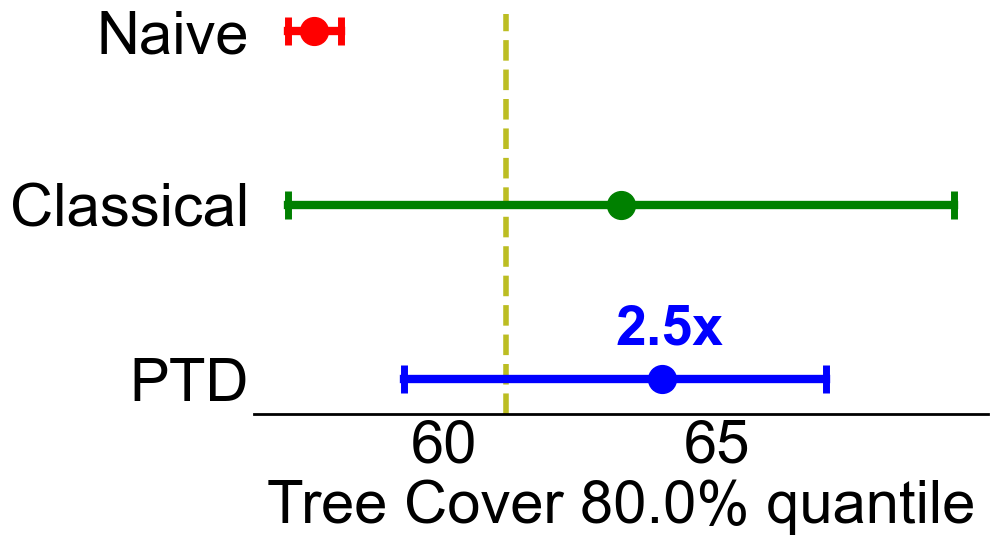

In [21]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=43)          
plt.rc('axes', titlesize=43)     
plt.rc('axes', labelsize=43)    
plt.rc('xtick', labelsize=43)    
plt.rc('ytick', labelsize=43)    
plt.rc('figure', titlesize=43)

variables = [f'Tree Cover {100*quantile}% quantile']
pd.set_option("display.precision", 8)

fig = plt.figure(figsize=(35, 6.5))
colors = ['blue', 'green', 'red']
for i, variable in enumerate(variables):
        
    data_dict = {}
    classical_ci_width = classical_ci[1][i] - classical_ci[0][i]
    ptd_ci_width = ptd_ci[1][i] - ptd_ci[0][i]
    data_dict['category'] = ['PTD','Classical','Naive']
    data_dict['lower'] = [ptd_ci[0][i], classical_ci[0][i], naive_ci[0][i]]
    data_dict['upper'] = [ptd_ci[1][i], classical_ci[1][i], naive_ci[1][i]]
    data_dict['pointestimate'] = [ptd_pointestimate[i], classical_pointestimate[i], naive_pointestimate[i]]
    dataset = pd.DataFrame(data_dict)
    
    subplot = fig.add_subplot(141+i)
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)
    subplot.spines['left'].set_visible(False)
    subplot.spines['bottom'].set_linewidth(2)
    
    # show true coefficient (yellow dotted line)
    plt.axvline(true_coeff[i], color='tab:olive', linestyle='--', lw=4, label='True \ncoefficient')
    
    # plot confidence intervals
    for lower,upper,pointestimate,y in zip(dataset['lower'],dataset['upper'],dataset['pointestimate'],range(len(dataset))):
        subplot.scatter([pointestimate], [y], color=colors[y], s=400)
        subplot.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=400, lw=5)
        subplot.plot((lower,upper),(y,y),color=colors[y], lw=6)
        if y == 0:
            # compute PTD effective sample size improvement over classical method
            ptd_effective_n_improvement = np.round((classical_ci_width/ptd_ci_width)**2, 1)
            subplot.text((lower+upper)/2, 0.2, f'{ptd_effective_n_improvement}x', fontsize = 40, c='blue', weight='bold')
            
    subplot.tick_params(axis=u'both', which=u'both',length=0)
    if i == 0:
        subplot.set_yticks(range(len(dataset)),list(dataset['category']))
    else:
        subplot.set_yticks([])
    subplot.set_xlabel(f'{variable}')
    subplot.set_ylim(-0.2)
    
plt.tight_layout()   
plt.show()

# Example 4: Weighted linear regression coefficient estimation

In this example, we show how to estimate linear regression coefficients when the calibration dataset is obtained by a weighted sampling scheme, such that some points are more likely to be sampled than others. 

We use the same setup as Example 1. The goal is to estimate linear regression coefficients relating tree cover to two covariates (elevation and population). The calibration set will be chosen using weighted sampling based on longitude, such that points in the east are more likely to be sampled than points in the west.  

In [22]:
truth_Y = np.array(data['truth_tree']).reshape(-1, 1)
preds_Y = np.array(data['preds_tree']).reshape(-1, 1)

truth_X = np.array(data[['truth_elevation', 'truth_population']])
preds_X = np.array(data[['truth_elevation', 'preds_population']])

For the weighted sampling, we first partition the dataset into 4 quartiles (i=1, 2, 3, 4) based on longitude, such that the westernmost quartile is i=1 and the easternmost quartile is i=4.

Each point in quartile i is given the score $$q(i)=5^i$$

Finally, we assign a sampling probability to each point by normalizing the scores to sum to 1. By design, points in the east will have a higher probability of being included in the calibration set than points in the west. 

In [23]:
np.random.seed(seed=100)
# map each point to its longitude quartile (1, 2, 3, or 4)
perc = np.percentile(data['lon'], [25,50,75])
data['quartile_number'] = 1 + np.digitize(data['lon'], perc)

# assign quartile scores q(i) = 5^i
data['quartile_score'] = np.array([5**i for i in data['quartile_number']])

# compute probability of sampling each point by normalizing the quartile scores to sum to 1 
data['probability'] = data['quartile_score']/data['quartile_score'].sum()

display(data)

,truth_tree,preds_tree,lon,lat,truth_elevation,preds_elevation,truth_population,preds_population,quartile_number,quartile_score,probability
0,0.00000000,0.00000000,-119.79401861,46.77315694,0.42391388,0.96378381,0.29098461,0.22361307,1,5,0.00000038
1,0.00000000,0.00000000,-107.44014215,36.62841178,2.01540807,1.77998188,0.07005862,1.08949520,1,5,0.00000038
2,32.51117590,42.11103850,-87.58028724,30.31625421,0.00505927,-0.01680112,1.77178479,2.92341369,3,125,0.00000943
3,1.70611111,0.00000000,-102.31679539,43.25048344,1.00007475,1.16428282,2.65432932,0.87253554,2,25,0.00000189
4,34.12197437,38.17914530,-97.66171151,29.81567453,0.14438043,0.31066607,1.53958068,1.78851923,2,25,0.00000189
...,...,...,...,...,...,...,...,...,...,...,...
67963,0.05636540,11.82932282,-99.74134957,32.53702611,0.52132315,0.42267153,3.77604851,3.56314923,2,25,0.00000189
67964,1.92631579,8.44263317,-83.35214891,41.01426028,0.25647059,0.17445653,3.06495415,2.71051530,4,625,0.00004714
67965,2.94700000,0.00000000,-86.85034805,36.65051239,0.16911172,0.12545899,4.12061274,3.16597032,3,125,0.00000943
67966,0.08406220,7.71593830,-99.90661882,31.50956468,0.49507440,0.48869264,0.94509188,1.09122816,2,25,0.00000189


Using these sampling probabilities, we randomly sample n=1000 points (out of the 67968 total points) to use as the calibration set. The remaining 66968 points are the unlabeled set.

In [24]:
# sample calibration set using the given probabilities
n = 1000
calibration_indices = np.random.choice(np.arange(0, len(data)), size=n, replace=False, p=data['probability'])

X = statsmodels.tools.add_constant(truth_X[calibration_indices])
Xhat = statsmodels.tools.add_constant(preds_X[calibration_indices])
Xhat_unlabeled = statsmodels.tools.add_constant(np.delete(preds_X, calibration_indices, axis=0)) # all predicted datapoints except calibration indices
Y = truth_Y[calibration_indices]
Yhat = preds_Y[calibration_indices]
Yhat_unlabeled = np.delete(preds_Y, calibration_indices, axis=0) # all predicted datapoints except calibration indices

In order to get approximately unbiased estimates of the linear regression coefficients, we will need to compute sample weights for the calibration set and the unlabeled set. 

We use Inverse Probability Weighting. A calibration point with sampling probability p has weight 1/p, while an unlabeled point with sampling probability p has weight 1/(1-p). 

In [25]:
# to compute sample weights, we need to rescale the probabilities so they sum to n (the number of calibration samples)
data['probability'] = n*data['probability']  

# sample weights (Inverse Probability Weighting)
w = (1/data['probability'])[calibration_indices].to_numpy()
w_unlabeled = np.delete(1/(1-data['probability']), calibration_indices, axis=0) # all predicted datapoints except calibration indices

We use the same functions as Example 1 to compute point estimates and confidence intervals for the linear regression coefficients. We will compare the true coefficient with the PTD, classical, and naive estimators. 

Note that we use the sample weights w and w_unlabeled as inputs to **ptd_linear_regression**. We also use w as an input to **classical_linear_regression_ci**. (We do not use any weights for the naive estimator, since it uses the full predicted dataset and does not use the calibration set.)

In [26]:
true_coeff = ptd.algorithm_linear_regression(data=[statsmodels.tools.add_constant(truth_X), truth_Y], w=None)

tuning_matrix, ptd_pointestimate, ptd_ci = ptd.ptd_linear_regression(X, Xhat, Xhat_unlabeled, Y, Yhat, Yhat_unlabeled, 
                                                                             w=w, w_unlabeled=w_unlabeled,
                                                                  B=2000, alpha=0.05, tuning_method='optimal')

classical_ci = classical_linear_regression_ci(X, Y, alpha=0.05, w=w)
classical_pointestimate = (classical_ci[0]+classical_ci[1])/2

naive_ci = classical_linear_regression_ci(statsmodels.tools.add_constant(preds_X), preds_Y, alpha=0.05)
naive_pointestimate = (naive_ci[0]+naive_ci[1])/2

We visualize the coefficient point estimates and confidence intervals for PTD, classical, and naive estimators.

The yellow dotted line is the "true coefficient." The effective sample size improvement of PTD compared to the classical confidence interval is shown in blue.

We see that the naive estimates are biased relative to the true coefficient, while PTD has statistically valid confidence intervals (which, in the figure, contain the true coefficient). The PTD confidence intervals are also narrower than the classical confidence intervals.

,category,lower,upper,pointestimate
0,PTD (weighted),28.01811321,38.96394310,34.74788264
1,Classical (weighted),18.81459014,52.99687891,35.90573453
2,Naive,29.20621500,30.22704453,29.71662976


,category,lower,upper,pointestimate
0,PTD (weighted),-17.29942190,-7.97645045,-13.65211767
1,Classical (weighted),-16.23255623,5.33752187,-5.44751718
2,Naive,-10.29206477,-9.58677065,-9.93941771


,category,lower,upper,pointestimate
0,PTD (weighted),-2.02773871,2.83060198,0.22872327
1,Classical (weighted),-5.53153851,4.61908689,-0.45622581
2,Naive,1.87056191,2.19331316,2.03193753


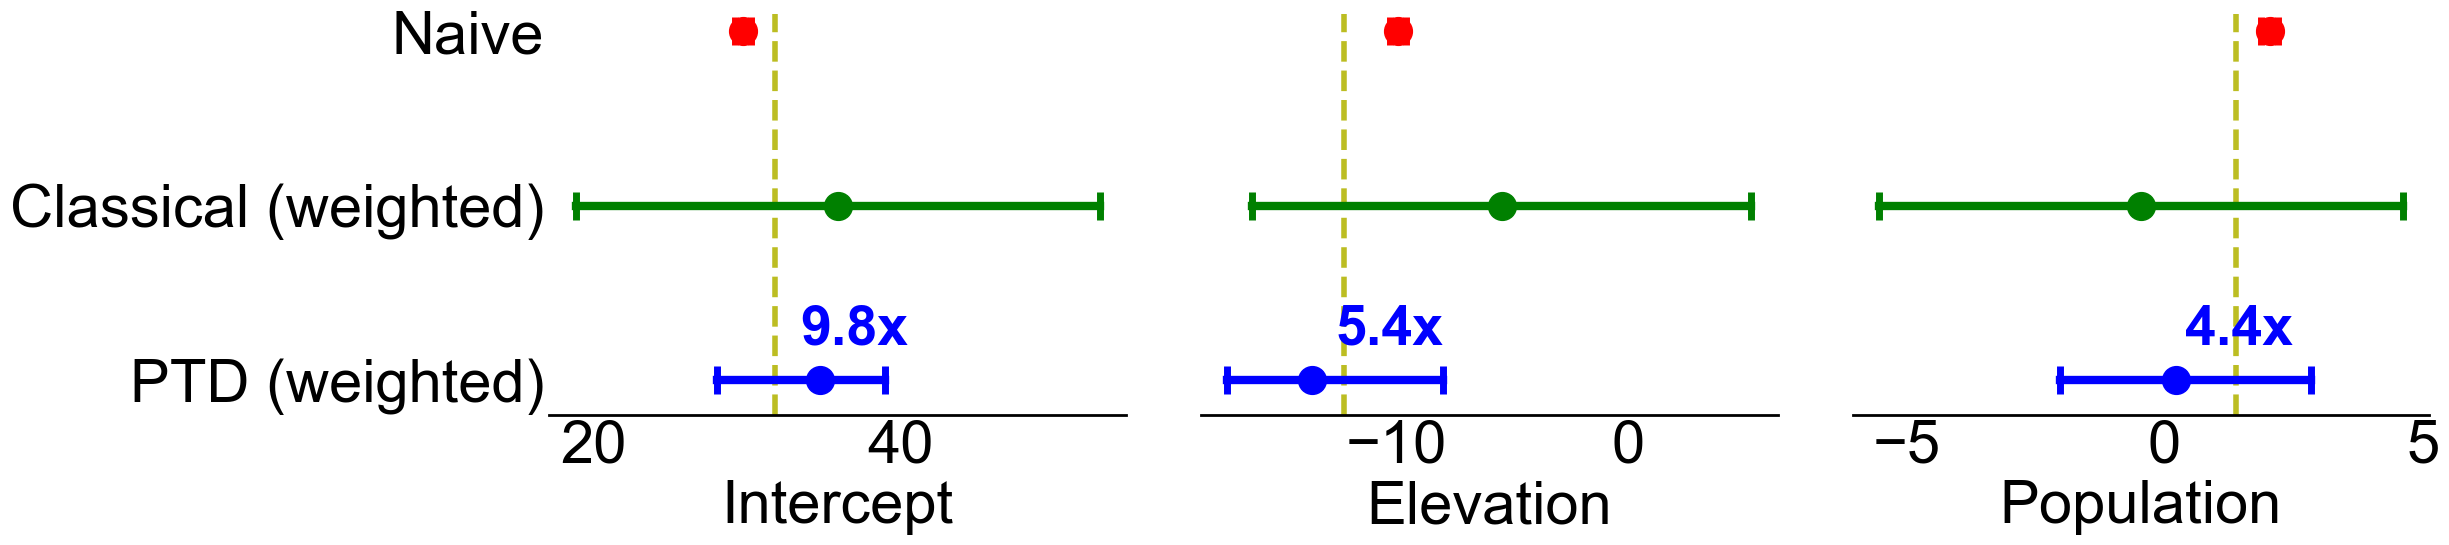

In [27]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=43)          
plt.rc('axes', titlesize=43)     
plt.rc('axes', labelsize=43)    
plt.rc('xtick', labelsize=43)    
plt.rc('ytick', labelsize=43)    
plt.rc('figure', titlesize=43)

covariates = ['Intercept', 'Elevation', 'Population']
pd.set_option("display.precision", 8)

fig = plt.figure(figsize=(32, 6.5))
colors = ['blue', 'green', 'red']
for i, covariate in enumerate(covariates):
        
    data_dict = {}
    classical_ci_width = classical_ci[1][i] - classical_ci[0][i]
    ptd_ci_width = ptd_ci[1][i] - ptd_ci[0][i]
    data_dict['category'] = ['PTD (weighted)', 'Classical (weighted)','Naive']
    data_dict['lower'] = [ptd_ci[0][i], classical_ci[0][i], naive_ci[0][i]]
    data_dict['upper'] = [ptd_ci[1][i], classical_ci[1][i], naive_ci[1][i]]
    data_dict['pointestimate'] = [ptd_pointestimate[i], classical_pointestimate[i], naive_pointestimate[i]]
    dataset = pd.DataFrame(data_dict)
    display(dataset)
    
    subplot = fig.add_subplot(141+i)
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)
    subplot.spines['left'].set_visible(False)
    subplot.spines['bottom'].set_linewidth(2)
    
    # show true coefficient (yellow dotted line)
    plt.axvline(true_coeff[i], color='tab:olive', linestyle='--', lw=4, label='True \ncoefficient')
    
    # plot confidence intervals
    for lower,upper,pointestimate,y in zip(dataset['lower'],dataset['upper'],dataset['pointestimate'],range(len(dataset))):
        subplot.scatter([pointestimate], [y], color=colors[y], s=400)
        subplot.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=400, lw=5)
        subplot.plot((lower,upper),(y,y),color=colors[y], lw=6)
        if y == 0:
            # compute PTD effective sample size improvement over classical method
            ptd_effective_n_improvement = np.round((classical_ci_width/ptd_ci_width)**2, 1)
            subplot.text((lower+upper)/2, 0.2, f'{ptd_effective_n_improvement}x', fontsize = 40, c='blue', weight='bold')
            
    subplot.tick_params(axis=u'both', which=u'both',length=0)
    if i == 0:
        subplot.set_yticks(range(len(dataset)),list(dataset['category']))
    else:
        subplot.set_yticks([])
    subplot.set_xlabel(f'{covariate}')
    subplot.set_ylim(-0.2)
    
plt.tight_layout()   
plt.show()